## DataSet

In [34]:
import pandas as pd
import math
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import binarize
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.model_selection import cross_val_score
import collections

In [2]:
df = pd.read_csv('/home/sundeepk/Downloads/corona_tested_individuals_ver_006.english.csv')

df.shape

/home/sundeepk/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(278848, 10)

In [3]:
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other


In [4]:
df['test_date'] = pd.to_datetime(df['test_date'])

## Descriptive Analysis

In [5]:
df['corona_result'].value_counts()

negative    260227
positive     14729
other         3892
Name: corona_result, dtype: int64

In [6]:
def disease_result(response):
    if response=='positive':
        return "COVID"
    else:
        return "Malaria"

In [7]:
from datetime import datetime

start_time = datetime.now()
print('start time: ', start_time)


df['disease_result'] = df['corona_result'].apply(disease_result)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start time:  2021-11-14 23:32:12.591412
Duration: 0:00:00.052737


## Exploratory Data Analysis

In [8]:
df['disease_result'].value_counts()

Malaria    264119
COVID       14729
Name: disease_result, dtype: int64

In [9]:
print("Start date:", min(df['test_date']))
print("End date:", max(df['test_date']))

n_days = (max(df['test_date']) - min(df['test_date'])).days
print("# of days: ", n_days)

n_obs =  df.shape[0]
print("# of observations:", df.shape[0])
print("# of features:", df.shape[1])

covid_cases = sum(df['disease_result'] == "COVID")
print("# of COVID diagnosed cases: {0} ({1: 2.2f}%)".format(covid_cases, 100*covid_cases / n_obs))

malaria_cases = sum(df['disease_result'] == "Malaria")
print("# of Malaria diagnosed cases: {0} ({1: 2.2f}%)".format(malaria_cases, 100 * malaria_cases / n_obs))

# other_cases = sum(df['corona_result'] == "other") # possibly not confirmed
# print("# of other cases (possibly, not confirmed): {0} ({1: 2.2f}%)".format(other_cases, 100 * other_cases / n_obs))

Start date: 2020-03-11 00:00:00
End date: 2020-04-30 00:00:00
# of days:  50
# of observations: 278848
# of features: 11
# of COVID diagnosed cases: 14729 ( 5.28%)
# of Malaria diagnosed cases: 264119 ( 94.72%)


In [10]:
date_counts = df.groupby(['test_date']).count()['gender']
date_counts = date_counts.sort_index()
cum_counts = date_counts.cumsum()
count = cum_counts / n_obs

In [11]:
max_training_date = count[count < 0.60].index.max()
training_data = df[df['test_date'] <= max_training_date]

min_test_date = count[count > 0.80].index.min()
test_data = df[df['test_date'] >= min_test_date]

valid_data = df[(max_training_date < df['test_date']) & (df['test_date'] < min_test_date)]

print("# of observations in training dataset", training_data.shape[0])
print("# of observations in validation dataset", valid_data.shape[0])
print("# of observations in test dataset", test_data.shape[0])

# of observations in training dataset 163189
# of observations in validation dataset 53848
# of observations in test dataset 61811


In [12]:
INPUT_FEATURES = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
TARGET_COLUMN = 'corona_result'

for col in INPUT_FEATURES:
  print("*"*25, f" {col} ", "*"*25)
  print(training_data[col].value_counts())

*************************  cough  *************************
0       121649
1        25875
0        12177
1         3236
None       252
Name: cough, dtype: int64
*************************  fever  *************************
0       133942
0        13934
1        13582
1         1479
None       252
Name: fever, dtype: int64
*************************  sore_throat  *************************
0       145028
0        16257
1         1457
1          446
None         1
Name: sore_throat, dtype: int64
*************************  shortness_of_breath  *************************
0       145438
0        16191
1         1047
1          512
None         1
Name: shortness_of_breath, dtype: int64
*************************  head_ache  *************************
0       144446
0        16354
1         2039
1          349
None         1
Name: head_ache, dtype: int64
*************************  age_60_and_above  *************************
No      125703
Yes      25825
None     11661
Name: age_60_and_above, dtype: 

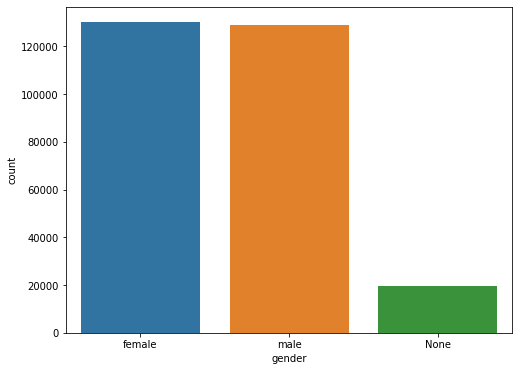

In [13]:
# figure to display gender column
import seaborn as sns
import warnings

warnings.simplefilter("ignore")


fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(df["gender"]);

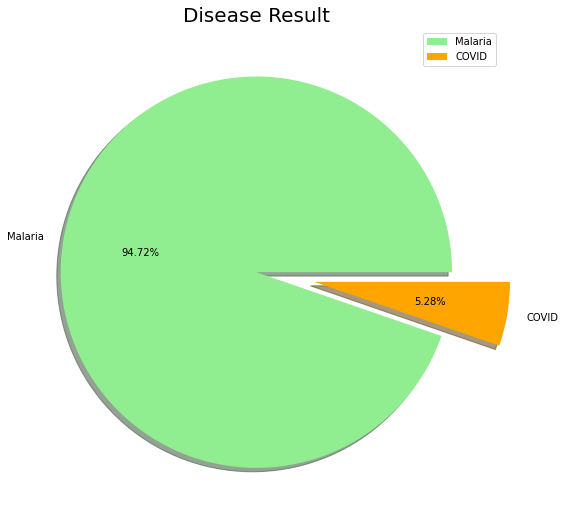

In [14]:
# disease result
labels = ['Malaria', 'COVID']
size = df['disease_result'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.3]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Disease Result', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

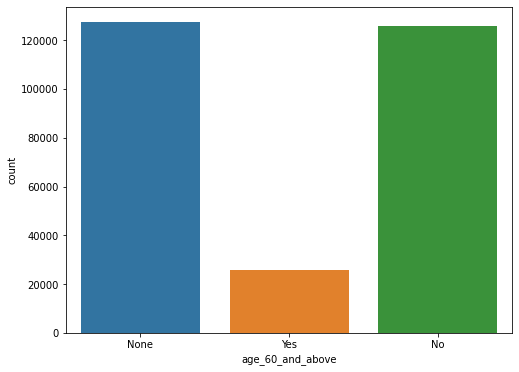

In [15]:
# figure to display age_60_and_above column

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(df["age_60_and_above"]);

In [16]:
df['gender'] = df['gender'].map({'male': 1, 'female': 0})

df['gender'].value_counts()

0.0    130158
1.0    129127
Name: gender, dtype: int64

In [17]:
#make categorical columns numerical
df['corona_result'] = df['corona_result'].map({'positive': 1, 'negative': 0})
df['disease_result'] = df['disease_result'].map({'Malaria': 1, 'COVID': 0})

df['disease_result'].value_counts()

1    264119
0     14729
Name: disease_result, dtype: int64

In [18]:
#  Change other and abroad to 0, Contact with confirmed to 1
df['test_indication'] = df['test_indication'].map({'Other': 0, 'Abroad': 0, 'Contact with confirmed': 1})

In [19]:
df['age_60_and_above'] = df['age_60_and_above'].map({'None': 0, 'No': -1, 'Yes': 1})

In [20]:
df.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,disease_result
0,2020-04-30,0,0,0,0,0,0.0,0,0.0,0,1
1,2020-04-30,1,0,0,0,0,0.0,0,0.0,0,1
2,2020-04-30,0,1,0,0,0,0.0,0,1.0,0,1
3,2020-04-30,1,0,0,0,0,0.0,0,0.0,0,1
4,2020-04-30,1,0,0,0,0,0.0,0,1.0,0,1


In [21]:
df_dropped_ = df.dropna()

df_dropped_.shape

(255911, 11)

In [22]:
df_dropped_.loc[df_dropped_.cough == 'None', 'cough'] = 0
df_dropped_.loc[df_dropped_.fever == 'None', 'fever'] = 0

In [23]:
df_dropped_['cough'] = df_dropped_['cough'].astype(np.int64)
df_dropped_['fever'] = df_dropped_['fever'].astype(np.int64)

In [24]:
df_dropped_["age_60_and_above"].value_counts()

 0    119374
-1    112788
 1     23749
Name: age_60_and_above, dtype: int64

## Train and Test Split

In [25]:
# x data
x = df_dropped_.drop(labels = ["test_date", "disease_result", "corona_result"], axis=1)
x.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication
0,0,0,0,0,0,0,0.0,0
1,1,0,0,0,0,0,0.0,0
2,0,1,0,0,0,0,1.0,0
3,1,0,0,0,0,0,0.0,0
4,1,0,0,0,0,0,1.0,0


In [26]:
# y data
y = df_dropped_["disease_result"]

### Balancing dataset

In [27]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
# X, y = oversample.fit_resample(x, y)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

In [29]:
sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

## Prediction

#### Fine-tuning classifiers with combination of parameters to get the best hypermater for the provided classifier

In [30]:
def params_tuning(model,X_train,y_train,X_test,y_test,metrics,param_grid,clf=False,conf=False):
    """Tune parameters of the model using a grid search, this function just makes the job easier."""
    gs=GridSearchCV(model,param_grid=param_grid,scoring=metrics,cv=10)
    gs.fit(X_train,y_train)
    predicted = gs.predict(X_test)
    proba = gs.predict_proba(X_test)[:,1]
    if clf == True:
        print (classification_report(y_test,predicted))
    if conf == True:
        print (confusion_matrix(y_test,predicted))
    print (gs.best_params_)
    print (roc_auc_score(y_test,proba),'Optimised Score')

### Classifiers:

### K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knnp = knn.predict_proba(X_test)
print (roc_auc_score(y_test,knnp[:,1]),"Initial Score")
weight_options = ['uniform','distance']
params_grid_knn = dict(n_neighbors = range(1,4) ,weights=weight_options)
params_tuning(knn,X_train,y_train,X_test,y_test,'roc_auc',params_grid_knn)

0.8555481527094841 Initial Score


### Random Forest

In [40]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rfpred=rf.predict(X_test)
rfp = dict(n_estimators=np.arange(5,25,10))
print (roc_auc_score(y_test,rfpred),'Initial Score')
params_tuning(rf,X_train,y_train,X_test,y_test,'roc_auc',rfp)

0.8460777117448808 Initial Score
{'n_estimators': 15}
0.8978798443292498 Optimised Score


### Adaptive Boosting

In [37]:
ada = AdaBoostClassifier(algorithm='SAMME')
ada.fit(X_train,y_train)
adaproba= ada.predict_proba(X_test)
print (roc_auc_score(y_test,adaproba[:,1]),'Initial Score')
adap = dict(n_estimators=[25,50,75],learning_rate =[0.25,0.5,0.75,1])
params_tuning(ada,X_train,y_train,X_test,y_test,'roc_auc',adap,clf=True)

0.8871997361066395 Initial Score
              precision    recall  f1-score   support

           0       0.41      0.75      0.53      2734
           1       0.99      0.94      0.96     48449

    accuracy                           0.93     51183
   macro avg       0.70      0.84      0.74     51183
weighted avg       0.95      0.93      0.94     51183

{'learning_rate': 1, 'n_estimators': 75}
0.8937817295883334 Optimised Score


### Logistic Regression

In [38]:
logreg = LogisticRegression(random_state=12)
logreg.fit(X_train,y_train)
logp = logreg.predict_proba(X_test)
print (roc_auc_score(y_test,logp[:,1]),"Inital Score")
# logp = dict(C=np.linspace(0.16,0.2),solver=['newton-cg', 'lbfgs'])
# params_tuning(logreg,X_train,y_train,X_test,y_test,'roc_auc',logp,clf=True)

0.8879159018232023 Inital Score


### Gradient Boosting Classifier

In [42]:
gbr = GradientBoostingClassifier()
gbr.fit(X_train,y_train)
gbrp = gbr.predict_proba(X_test)
print (roc_auc_score(y_test,gbrp[:,1]),'Initial Score')

0.8979090041711294 Initial Score


### Model Performance Comparision

In [35]:
scores_list= pd.DataFrame(collections.OrderedDict([('Model',['K Neighbors','Logistic Regression','Random Forest','Adaptive Boosting','Gradient Boosting']),('AUC_Score',[0.8555481527094841,0.8879159018232023,0.8978681426451298,0.8937817295883334,0.8979090041711294])])) 
print (scores_list.sort_values('AUC_Score',ascending=False))

                 Model  AUC_Score
4    Gradient Boosting   0.897909
2        Random Forest   0.897868
3    Adaptive Boosting   0.893782
1  Logistic Regression   0.887916
0          K Neighbors   0.855548


For COVID dataset, after cleaning and pre-processing the data and hypermater traing with various classifiers we observed that Gradient Boosting Classifier classifier gave the best accuracy of 89.79%

### Usage of best model to predict

In [46]:
model = rf
cough = int(input('Cough (Yes:1 / No:0): '))
fever = int(input('Fever (Yes:1 / No:0): '))
sore_throat = int(input('Sore throat (Yes:1 / No:0): '))
shortness_of_breath = int(input('Shortness of breath (Yes:1 / No:0): '))
headache = int(input('Headache (Yes:1 / No:0): '))
gender = int(input('Gender (male: 1/ female:0): '))
contact = int(input('Contact with confirmed (Yes:1 / No:0): '))
age_60_and_above = int(input('Age 60+ (Yes:1 / No:0): '))

predicted = model.predict([[cough, fever, sore_throat, shortness_of_breath, headache, age_60_and_above, gender, contact]])

if predicted == 0:
    output = 'COVID'
else:
    output = 'Malaria'

print('')
print(f'The Patient is effected with {output}')

Cough (Yes:1 / No:0): 0
Fever (Yes:1 / No:0): 0
Sore throat (Yes:1 / No:0): 0
Shortness of breath (Yes:1 / No:0): 0
Headache (Yes:1 / No:0): 0
Gender (male: 1/ female:0): 0
Contact with confirmed (Yes:1 / No:0): 0
Age 60+ (Yes:1 / No:0): 0

The Patient is effected with Malaria


In [47]:
model = rf
cough = int(input('Cough (Yes:1 / No:0): '))
fever = int(input('Fever (Yes:1 / No:0): '))
sore_throat = int(input('Sore throat (Yes:1 / No:0): '))
shortness_of_breath = int(input('Shortness of breath (Yes:1 / No:0): '))
headache = int(input('Headache (Yes:1 / No:0): '))
gender = int(input('Gender (male: 1/ female:0): '))
contact = int(input('Contact with confirmed (Yes:1 / No:0): '))
age_60_and_above = int(input('Age 60+ (Yes:1 / No:0): '))

predicted = model.predict([[cough, fever, sore_throat, shortness_of_breath, headache, age_60_and_above, gender, contact]])

if predicted == 0:
    output = 'COVID'
else:
    output = 'Malaria'

print('')
print(f'The Patient is effected with {output}')

Cough (Yes:1 / No:0): 1
Fever (Yes:1 / No:0): 1
Sore throat (Yes:1 / No:0): 0
Shortness of breath (Yes:1 / No:0): 0
Headache (Yes:1 / No:0): 0
Gender (male: 1/ female:0): 1
Contact with confirmed (Yes:1 / No:0): 1
Age 60+ (Yes:1 / No:0): 0

The Patient is effected with COVID
